In [1]:
import os
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from torch import nn, optim
from PIL import Image
import math
import torch.nn.functional as F
from torch.nn import Parameter
file_dir  = "../input/humpback-whale-identification/train"
df = pd.read_csv("../input/humpback-whale-identification/train.csv")

plt.hist(df["Id"])

In [2]:
train = df[df["Id"] != "new_whale"]
train.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
6,000a6daec.jpg,w_dd88965
8,0016b897a.jpg,w_64404ac


plt.hist(train["Id"])

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
def get_encoder(x):
    values = np.array(x)
    le = LabelEncoder()
    int_label =le.fit_transform(values)    
    ohe = OneHotEncoder(sparse =False)
    int_label = int_label.reshape(len(int_label),1)
    ohe.fit(int_label)
    return le,ohe

In [4]:
le, ohe = get_encoder(train["Id"])

In [5]:
def prepare_label(x,le,ohe):
    values = np.array(x)   
    int_label = le.transform(values)
    
    #int_label = int_label.reshape(len(int_label),1)
    #onehot_label = ohe.transform(int_label)
    
    #y = onehot_label
    y = int_label
    return y

In [6]:
import random
val_id = train["Id"].value_counts()[train["Id"].value_counts()>=6]
val_set = train[train["Id"].isin(val_id.index)]
val_idx = []
for i in val_id.index:
    sets = list(val_set.loc[val_set.Id == i].Id.index.values)
    val_idx+=random.sample(sets,2)
print(len(val_idx))
    
val_id = train["Id"].value_counts()[(train["Id"].value_counts()<6) & (train["Id"].value_counts()>3)]
val_set = train[train["Id"].isin(val_id.index)]
for i in val_id.index:
    sets = list(val_set.loc[val_set.Id == i].Id.index.values)
    val_idx+=random.sample(sets,1)
    if len(val_idx) >= 1300:
        break

        
val_id = train["Id"].value_counts()[train["Id"].value_counts()<3]
val_set = train[train["Id"].isin(val_id.index)]
oversample_val_idx = []
for i in val_id.index:
    sets = list(val_set.loc[val_set.Id == i].Id.index.values)
    oversample_val_idx+=random.sample(sets,1)
    if len(oversample_val_idx) >= 200:
        break

1266


In [7]:
val = train.loc[train.index.isin(val_idx)]
oversample_val = train.loc[train.index.isin(oversample_val_idx)]
train = train.loc[~train.index.isin(val_idx)]
val = pd.concat((val, oversample_val), axis = 0)
len(val)

1500

In [8]:
train.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
6,000a6daec.jpg,w_dd88965
8,0016b897a.jpg,w_64404ac


In [9]:
train_labels = prepare_label(train["Id"],le,ohe)
val_labels = prepare_label(val["Id"],le,ohe)

In [10]:
class WhaleDataset(Dataset):
    def __init__(self, df, file_dir, labels = None, mode = "train", transform = None):
        self.df = df
        self.file_dir = file_dir
        self.labels = labels
        self.mode = mode
        self.transform = transform
        
    def __getitem__(self, index):
        image_name = self.df["Image"].iloc[index]
        label = self.labels[index]
        
        image = Image.open(os.path.join(self.file_dir,image_name))
        image = image.resize((512,512))
        image = image.convert("RGB")
        
        if self.transform != None:
            image = self.transform(image)
        if self.mode == "train" or self.mode == "val":
            return image, label
        else:
            return image
    
    def __len__(self):
        return self.df.shape[0]

In [11]:
flip_transform = transforms.Compose([transforms.RandomHorizontalFlip(p=1),
                                     transforms.RandomGrayscale(),
                                     transforms.RandomRotation(15),
                                     transforms.GaussianBlur(3),
                                     transforms.RandomPerspective(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
regular_transform = transforms.Compose([transforms.RandomGrayscale(),
                                        transforms.RandomRotation(15),
                                        transforms.GaussianBlur(3), 
                                        transforms.RandomPerspective(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
val_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

In [12]:
train_data = WhaleDataset(train, file_dir, labels = train_labels, transform =regular_transform)
new_data = WhaleDataset(train, file_dir, labels = train_labels, transform =flip_transform)
val_data = WhaleDataset(val, file_dir, labels = val_labels, transform =val_transform)
train_data = torch.utils.data.ConcatDataset([train_data, new_data])

In [13]:
train_loader = DataLoader(train_data, batch_size = 32, shuffle=True)
val_loader = DataLoader(val_data, batch_size = 32, shuffle=True)

In [14]:
train_loader = torch.load("../input/arcfaceresnet34/train_loader.pt")
val_loader = torch.load("../input/arcfaceresnet34/val_loader.pt")

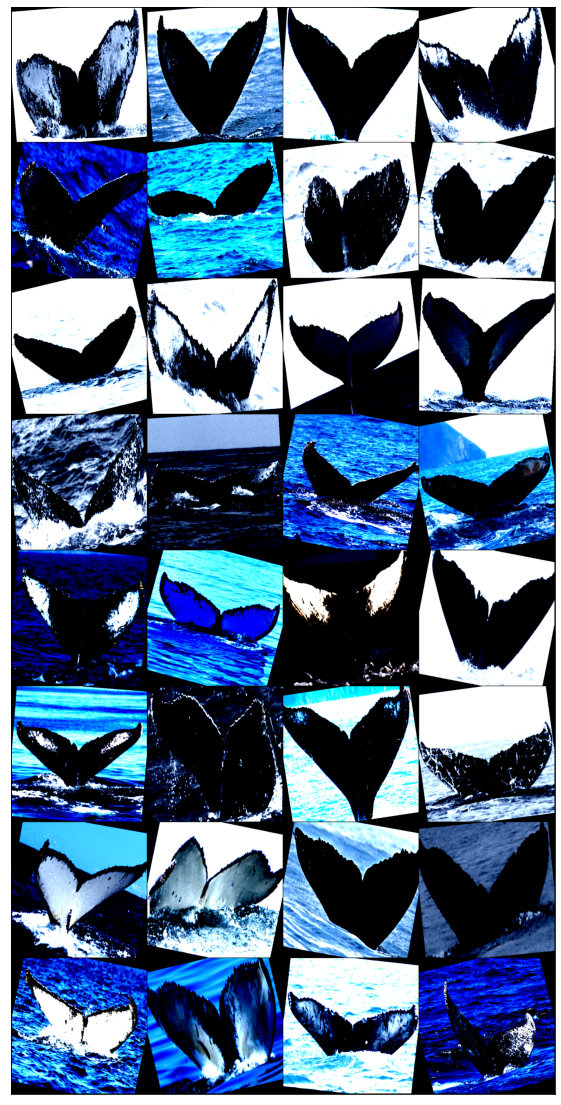

In [15]:
for images, labels in train_loader:
    
    fig, ax = plt.subplots(figsize = (20, 20))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(images, nrow=4).permute(1,2,0))
    break

In [16]:
class ArcMarginProduct(nn.Module):
    r"""Mortify From "https://github.com/ronghuaiyang/arcface-pytorch/blob/master/models/metrics.py"
        Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features, s=30.0, m=0.50, easy_margin=False):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, train=False, label=None):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(1e-6, 1))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        if train:
            one_hot = torch.zeros(cosine.size(), device='cuda')
            one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
            output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4
            output *= self.s
            # print(output)
        else:
            output = cosine

        return output

import torchvision.models as models
model = models.resnet34(pretrained=True)
for p in model.parameters():
    p.requires_grad = False
model.fc = nn.Sequential(nn.Dropout(p=0.5),
                         nn.Linear(512,1024))
arcface_fc = ArcMarginProduct(1024,5004,s=30, m=0.5)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


model = torch.load("../input/arcfaceresnet34/HumpbackWhale-resnet34.h5",map_location=torch.device('cpu'))
arcface_fc = torch.load("../input/arcfaceresnet34/HumpbackWhale-arcface_fc.h5",map_location=torch.device('cpu'))

In [18]:
model = torch.load("../input/arcfaceresnet34/HumpbackWhale-resnet34.h5")
arcface_fc = torch.load("../input/arcfaceresnet34/HumpbackWhale-arcface_fc.h5")

model = torch.load("../input/arcfaceresnet34/HumpbackWhale-resnet34.h5")
arcface_fc = torch.load("../input/arcfaceresnet34/HumpbackWhale-arcface_fc.h5")

for p in model.parameters():
    p.requires_grad = False
model.fc = nn.Linear(512,1024)

In [19]:
model = model.to(device)
arcface_fc = arcface_fc.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
criterion = nn.CrossEntropyLoss()

model = torch.load("../input/humpackwhalemodel/HumpbackWhale6.h5")

optimizer = torch.optim.Adam(model.parameters(), lr=1.25e-5, weight_decay=1e-4)

from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 1
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        pred_outputs = arcface_fc(outputs)
        outputs = arcface_fc(outputs, True, labels)

        _, preds = torch.max(pred_outputs.data,1)
        train_num_correct += (preds == labels).sum().item()
        train_num_predictions += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
            
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
 
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            pred_outputs = arcface_fc(outputs)
            outputs = arcface_fc(outputs, True, labels)

            _, preds = torch.max(pred_outputs.data,1)
            val_num_correct += (preds == labels).sum().item()
            val_num_predictions += labels.size(0)      
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))
    

optimizer = torch.optim.Adam(model.parameters(), lr=6.25e-6, weight_decay=1e-4)

from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 1
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        pred_outputs = arcface_fc(outputs)
        outputs = arcface_fc(outputs, True, labels)

        _, preds = torch.max(pred_outputs.data,1)
        train_num_correct += (preds == labels).sum().item()
        train_num_predictions += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
            
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
 
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            pred_outputs = arcface_fc(outputs)
            outputs = arcface_fc(outputs, True, labels)

            _, preds = torch.max(pred_outputs.data,1)
            val_num_correct += (preds == labels).sum().item()
            val_num_predictions += labels.size(0)      
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

for p in model.parameters():
    p.requires_grad = True

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 4)

In [22]:
from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 4
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        pred_outputs = arcface_fc(outputs)
        outputs = arcface_fc(outputs, True, labels)

        _, preds = torch.max(pred_outputs.data,1)
        train_num_correct += (preds == labels).sum().item()
        train_num_predictions += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    scheduler.step()    
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
 
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            pred_outputs = arcface_fc(outputs)
            outputs = arcface_fc(outputs, True, labels)

            _, preds = torch.max(pred_outputs.data,1)
            val_num_correct += (preds == labels).sum().item()
            val_num_predictions += labels.size(0)      
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

100%|██████████| 47/47 [00:56<00:00,  1.20s/it]


[Epoch: 1 / 4], [Trian loss: 2.374289], [Val loss: 6.463355], [Train_Acc: 100.00], [Val_Acc: 85.33]


100%|██████████| 47/47 [00:43<00:00,  1.09it/s]


[Epoch: 2 / 4], [Trian loss: 2.241106], [Val loss: 6.252655], [Train_Acc: 100.00], [Val_Acc: 85.93]


100%|██████████| 47/47 [00:43<00:00,  1.08it/s]


[Epoch: 3 / 4], [Trian loss: 1.986875], [Val loss: 6.127372], [Train_Acc: 100.00], [Val_Acc: 85.53]


100%|██████████| 47/47 [00:43<00:00,  1.09it/s]

[Epoch: 4 / 4], [Trian loss: 1.794915], [Val loss: 6.030631], [Train_Acc: 100.00], [Val_Acc: 85.60]


In [25]:
optimizer.param_groups[-1]["lr"] = 2.5e-5
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 4)

In [26]:
from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 4
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        pred_outputs = arcface_fc(outputs)
        outputs = arcface_fc(outputs, True, labels)

        _, preds = torch.max(pred_outputs.data,1)
        train_num_correct += (preds == labels).sum().item()
        train_num_predictions += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    scheduler.step()    
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
 
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            pred_outputs = arcface_fc(outputs)
            outputs = arcface_fc(outputs, True, labels)

            _, preds = torch.max(pred_outputs.data,1)
            val_num_correct += (preds == labels).sum().item()
            val_num_predictions += labels.size(0)      
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

100%|██████████| 47/47 [00:43<00:00,  1.08it/s]


[Epoch: 1 / 4], [Trian loss: 1.842823], [Val loss: 6.123210], [Train_Acc: 99.99], [Val_Acc: 86.00]


100%|██████████| 47/47 [00:43<00:00,  1.07it/s]


[Epoch: 2 / 4], [Trian loss: 1.773031], [Val loss: 6.096943], [Train_Acc: 100.00], [Val_Acc: 85.53]


100%|██████████| 47/47 [00:43<00:00,  1.08it/s]


[Epoch: 3 / 4], [Trian loss: 1.655697], [Val loss: 6.005824], [Train_Acc: 100.00], [Val_Acc: 85.53]


100%|██████████| 47/47 [00:43<00:00,  1.09it/s]

[Epoch: 4 / 4], [Trian loss: 1.568982], [Val loss: 6.011917], [Train_Acc: 100.00], [Val_Acc: 85.53]


In [34]:
optimizer.param_groups[-1]["lr"] = 2.5e-5
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 4)

In [38]:
from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 4
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        pred_outputs = arcface_fc(outputs)
        outputs = arcface_fc(outputs, True, labels)

        _, preds = torch.max(pred_outputs.data,1)
        train_num_correct += (preds == labels).sum().item()
        train_num_predictions += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    scheduler.step()    
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
 
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            pred_outputs = arcface_fc(outputs)
            outputs = arcface_fc(outputs, True, labels)

            _, preds = torch.max(pred_outputs.data,1)
            val_num_correct += (preds == labels).sum().item()
            val_num_predictions += labels.size(0)      
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

100%|██████████| 47/47 [00:43<00:00,  1.08it/s]


[Epoch: 1 / 4], [Trian loss: 1.681139], [Val loss: 6.096472], [Train_Acc: 100.00], [Val_Acc: 85.40]


 77%|███████▋  | 695/900 [22:29<06:38,  1.94s/it]


KeyboardInterrupt: 

from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 2
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        pred_outputs = arcface_fc(outputs)
        outputs = arcface_fc(outputs, True, labels)

        _, preds = torch.max(pred_outputs.data,1)
        train_num_correct += (preds == labels).sum().item()
        train_num_predictions += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    scheduler.step()    
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
 
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            pred_outputs = arcface_fc(outputs)
            outputs = arcface_fc(outputs, True, labels)

            _, preds = torch.max(pred_outputs.data,1)
            val_num_correct += (preds == labels).sum().item()
            val_num_predictions += labels.size(0)      
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

optimizer.param_groups[-1]["lr"] = 5e-6

from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 1
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        pred_outputs = arcface_fc(outputs)
        outputs = arcface_fc(outputs, True, labels)

        _, preds = torch.max(pred_outputs.data,1)
        train_num_correct += (preds == labels).sum().item()
        train_num_predictions += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
 
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            pred_outputs = arcface_fc(outputs)
            outputs = arcface_fc(outputs, True, labels)

            _, preds = torch.max(pred_outputs.data,1)
            val_num_correct += (preds == labels).sum().item()
            val_num_predictions += labels.size(0)      
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 1
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        pred_outputs = arcface_fc(outputs)
        outputs = arcface_fc(outputs, True, labels)

        _, preds = torch.max(pred_outputs.data,1)
        train_num_correct += (preds == labels).sum().item()
        train_num_predictions += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
 
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            pred_outputs = arcface_fc(outputs)
            outputs = arcface_fc(outputs, True, labels)

            _, preds = torch.max(pred_outputs.data,1)
            val_num_correct += (preds == labels).sum().item()
            val_num_predictions += labels.size(0)      
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 1
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        pred_outputs = arcface_fc(outputs)
        outputs = arcface_fc(outputs, True, labels)

        _, preds = torch.max(pred_outputs.data,1)
        train_num_correct += (preds == labels).sum().item()
        train_num_predictions += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
 
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            pred_outputs = arcface_fc(outputs)
            outputs = arcface_fc(outputs, True, labels)

            _, preds = torch.max(pred_outputs.data,1)
            val_num_correct += (preds == labels).sum().item()
            val_num_predictions += labels.size(0)      
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))
    

optimizer = torch.optim.Adam(model.parameters(), lr=1.25e-5)

optimizer.param_groups[-1]["lr"] = 2.5e-5

from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 2
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        outputs = arcface_fc(outputs, True, labels)

        _, preds = torch.max(outputs.data,1)
        train_num_correct += (preds == labels).sum().item()
        train_num_predictions += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
 
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            pred_outputs = arcface_fc(outputs, False, labels)
            outputs = arcface_fc(outputs, True, labels)

            _, preds = torch.max(pred_outputs.data,1)
            val_num_correct += (preds == labels).sum().item()
            val_num_predictions += labels.size(0)      
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Train_Acc: %.2f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 2
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        outputs = arcface_fc(outputs, True, labels)

        _, preds = torch.max(outputs.data,1)
        train_num_correct += (preds == labels).sum().item()
        train_num_predictions += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
 
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            pred_outputs = arcface_fc(outputs, False, labels)
            outputs = arcface_fc(outputs, True, labels)

            _, preds = torch.max(pred_outputs.data,1)
            val_num_correct += (preds == labels).sum().item()
            val_num_predictions += labels.size(0)      
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], train_accuracy, val_accuracy))

from tqdm import tqdm

train_losses = []
val_losses = []
num_epochs = 1
for epoch in range(num_epochs):
    train_num_correct = 0
    train_num_predictions = 0
    model.train()
    running_loss = 0
    
    for images, labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        outputs = arcface_fc(outputs, True, labels)

        _, preds = torch.max(outputs.data,1)
        train_num_correct += (preds == labels).sum().item()
        train_num_predictions += labels.size(0)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    train_accuracy = train_num_correct / train_num_predictions * 100
    train_losses.append(running_loss / len(train_loader))
 
    model.eval()    
    running_loss = 0
    val_num_correct = 0
    val_num_predictions = 0
    with torch.no_grad():  
        for images, labels in tqdm(val_loader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            pred_outputs = arcface_fc(outputs)
            outputs = arcface_fc(outputs, True, labels)

            _, preds = torch.max(pred_outputs.data,1)
            val_num_correct += (preds == labels).sum().item()
            val_num_predictions += labels.size(0)      
            
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    
    val_accuracy = val_num_correct / val_num_predictions * 100
    val_losses.append(running_loss / len(val_loader))
    print("[Epoch: %d / %d], [Trian loss: %.6f], [Val loss: %.6f], [Val_Acc: %.2f]" \
          %(epoch+1, num_epochs, train_losses[-1], val_losses[-1], val_accuracy))

In [27]:
torch.save(train_loader, 'train_loader.pt')
torch.save(val_loader, 'val_loader.pt')
torch.save(model, "HumpbackWhale-resnet34.h5")
torch.save(arcface_fc, "HumpbackWhale-arcface_fc.h5")

from sklearn.model_selection import train_test_split
new_whale_df = df[df["Id"] == "new_whale"]
_, val_new_whale = train_test_split(new_whale_df, test_size=0.043)
val.shape,val_new_whale.shape

from sklearn.model_selection import train_test_split
_, val = train_test_split(df, test_size=0.1)
val.shape

In [33]:
file_dir  = "../input/humpback-whale-identification/train"

val = pd.concat((val_new_whale, val), axis = 0)

model.eval()
pred = None
for i in range(val.shape[0]):
    with torch.no_grad():
        image_name = val["Image"].iloc[i]
        image = Image.open(os.path.join(file_dir,image_name))
        image = image.resize((384,384))
        image = image.convert("RGB")
        image = val_transform(image)
        image = image.to(device)
        if pred is None:
            pred = model(image.unsqueeze(0))
            pred = arcface_fc(pred).cpu().detach().numpy()
        else:
            result = model(image.unsqueeze(0))
            result = arcface_fc(result).cpu().detach().numpy()
            pred = np.concatenate((pred, result),axis = 0)
pred = np.concatenate((np.zeros((pred.shape[0],1)), pred),axis = 1)
pred

In [28]:
label_set = ['new_whale']+list(le.classes_)

def map5(X, y, label_set):
    score = 0
    for i in range(X.shape[0]):
        pred = X[i].argsort()[-5:][::-1]
        for j in range(pred.shape[0]):
            if label_set[pred[j]] == y[i]:
                score += (5 - j)/5
                break
                
    return float(score/X.shape[0])

best_th = 0
best_score = 0
y = np.array(val["Id"])
for th in np.arange(-1, 1, 0.05):
    pred[:,0] = th
    score = map5(pred, y, label_set)
    if score > best_score:
        best_score = score
        best_th = th
    print("Threshold = {:.3f}, MAP5 = {:.3f}".format(th,score))

print("Best Threshold = {:.3f}, Best MAP5 = {:.3f}".format(best_th,best_score))

In [29]:
file_dir  = "../input/humpback-whale-identification/test"
sample = pd.read_csv("../input/humpback-whale-identification/sample_submission.csv")
sample.head()

,Image,Id
0,00028a005.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
1,000dcf7d8.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
2,000e7c7df.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
3,0019c34f4.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
4,001a4d292.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c


sample.shape[0]

In [30]:
model.eval()
pred = None
for i in range(sample.shape[0]):
    with torch.no_grad():
        file_name = sample["Image"][i] 
        image = Image.open(os.path.join(file_dir,file_name))
        image = image.resize((512,512))
        image = image.convert("RGB")
        image = val_transform(image)
        image = image.to(device)
        if pred is None:
            pred = model(image.unsqueeze(0))
            pred = arcface_fc(pred).cpu().detach().numpy()
        else:
            result = model(image.unsqueeze(0))
            result = arcface_fc(result).cpu().detach().numpy()
            pred = np.concatenate((pred, result),axis = 0)
pred = np.concatenate((np.zeros((pred.shape[0],1)), pred),axis = 1)
pred

array([[ 0.        , -0.03495409,  0.01162893, ..., -0.00639903,
         0.00346424, -0.01066293],
       [ 0.        ,  0.02223545, -0.02342371, ..., -0.0272213 ,
         0.01213785,  0.01346602],
       [ 0.        , -0.06822944,  0.00343501, ..., -0.00229889,
         0.03124695,  0.00592395],
       ...,
       [ 0.        , -0.01020575,  0.04760191, ...,  0.03255043,
         0.00463803, -0.03350054],
       [ 0.        , -0.04446416,  0.03940817, ...,  0.01543637,
        -0.03381717, -0.00095151],
       [ 0.        , -0.02757008,  0.04974791, ..., -0.0176474 ,
        -0.02698729, -0.01766817]])

In [31]:
pred[:,0] = 0.3

In [32]:
result = {}
for i in range(pred.shape[0]):
    file_name = sample["Image"][i]
    result[file_name] = ""
    top5 = pred[i].argsort()[-5:][::-1]
    for j in range(top5.shape[0]):
        if result[file_name] != "":
            result[file_name] += " "
            result[file_name] += label_set[top5[j]]
        else:
            result[file_name] += label_set[top5[j]]

In [36]:
submission = pd.DataFrame(result.items(), columns = ["Image", "Id"])
submission.head()

,Image,Id
0,00028a005.jpg,new_whale w_50e2184 w_1be76f5 w_1b4bb29 w_7860ed5
1,000dcf7d8.jpg,w_4132bb8 w_e3956f5 new_whale w_c84b36b w_d6666c9
2,000e7c7df.jpg,new_whale w_8d76b75 w_94c3bf0 w_4c07458 w_030c8b0
3,0019c34f4.jpg,w_c99807e w_a335fc2 new_whale w_08630fd w_d1207d9
4,001a4d292.jpg,new_whale w_9e18daa w_a354653 w_c5ee28a w_d3311fa


In [37]:
submission.to_csv("humpack-submission.csv", index = False)